In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
import csv
from tqdm import tqdm
import pandas as pd

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions

In [2]:
output_dir = os.path.join(".", "output_right_ppo")  # Path to the output directory
subdirs = [f.path for f in os.scandir(output_dir) if f.is_dir()]
subdirs.sort()

# Create an empty 3D array to store the combined data
combined_arr = np.empty((len(subdirs), 1000, 10))

# Loop through each subdirectory and load the CSV files
for i, subdir in enumerate(subdirs):
    action_filename = os.path.join(subdir, "action.csv")
    obs_filename = os.path.join(subdir, "obs.csv")

    # Load the action and obs CSV files
    action_df = pd.read_csv(action_filename,  header=None)
    obs_df = pd.read_csv(obs_filename,  header=None)

    # Concatenate the DataFrames horizontally
    combined_data = pd.concat([action_df, obs_df], axis=1)

    # Convert combined_data to a 3D array and assign it to combined_arr
    combined_arr[i-1] = np.reshape(combined_data.values, (1000, 10))

# Print the shape of combined_arr
print(combined_arr.shape)
combined_tensor = torch.from_numpy(combined_arr)

(10000, 1000, 10)


# VAE code -1

====> Epoch: 1 Average loss: 0.005626243625368391, Recon Loss: 0.0018594801085335868, KL Div: 0.018833817413875034
====> Epoch: 2 Average loss: 0.00491283461025783, Recon Loss: 0.0018589381405285427, KL Div: 0.015269482135772705
====> Epoch: 3 Average loss: 0.0046061444112232754, Recon Loss: 0.0018576735598700388, KL Div: 0.013742354052407401
====> Epoch: 4 Average loss: 0.004112434233937944, Recon Loss: 0.001856189719268254, KL Div: 0.011281222411564418
====> Epoch: 5 Average loss: 0.003610114336013794, Recon Loss: 0.0018544412084988185, KL Div: 0.00877836547579084
====> Epoch: 6 Average loss: 0.00305632175718035, Recon Loss: 0.00185251156772886, KL Div: 0.006019051040921893
====> Epoch: 7 Average loss: 0.002553908109664917, Recon Loss: 0.001850384167262486, KL Div: 0.00351761965240751
====> Epoch: 8 Average loss: 0.0022069314888545446, Recon Loss: 0.0018482107605252947, KL Div: 0.0017936036927359445
====> Epoch: 9 Average loss: 0.002010627210140228, Recon Loss: 0.001845790207386017, 

====> Epoch: 71 Average loss: 0.000830685977424894, Recon Loss: 0.0008276339173316956, KL Div: 1.5260279178619383e-05
====> Epoch: 72 Average loss: 0.0008059433656079428, Recon Loss: 0.0008032532462051937, KL Div: 1.345060978616987e-05
====> Epoch: 73 Average loss: 0.0007889006052698408, Recon Loss: 0.0007860121812139239, KL Div: 1.4442111764635358e-05
====> Epoch: 74 Average loss: 0.000767518298966544, Recon Loss: 0.0007642871609755924, KL Div: 1.615570272718157e-05
====> Epoch: 75 Average loss: 0.0007530858601842608, Recon Loss: 0.0007495217706475939, KL Div: 1.782047748565674e-05
====> Epoch: 76 Average loss: 0.0007335569730826787, Recon Loss: 0.0007311555232320513, KL Div: 1.2007253510611397e-05
====> Epoch: 77 Average loss: 0.0007178620525768825, Recon Loss: 0.0007152123919555119, KL Div: 1.3248294591903686e-05
====> Epoch: 78 Average loss: 0.0007054053970745632, Recon Loss: 0.0007022627208914076, KL Div: 1.5713410718100413e-05
====> Epoch: 79 Average loss: 0.0006877198687621525, 

====> Epoch: 140 Average loss: 0.0004517952161175864, Recon Loss: 0.00045094128378799983, KL Div: 4.269672291619437e-06
====> Epoch: 141 Average loss: 0.00045127904628004345, Recon Loss: 0.00045051602380616324, KL Div: 3.815131528036935e-06
====> Epoch: 142 Average loss: 0.00045083368676049367, Recon Loss: 0.0004498814621141979, KL Div: 4.761125360216413e-06
====> Epoch: 143 Average loss: 0.00045051315213952747, Recon Loss: 0.0004487637366567339, KL Div: 8.74707954270499e-06
====> Epoch: 144 Average loss: 0.0004487148906503405, Recon Loss: 0.00044783524104527066, KL Div: 4.398256540298462e-06
====> Epoch: 145 Average loss: 0.0004465978103024619, Recon Loss: 0.0004457343603883471, KL Div: 4.31726234299796e-06
====> Epoch: 146 Average loss: 0.00044717713126114436, Recon Loss: 0.0004462501449244363, KL Div: 4.63491678237915e-06
====> Epoch: 147 Average loss: 0.00044624812262398855, Recon Loss: 0.0004454818389245442, KL Div: 3.83141211100987e-06
====> Epoch: 148 Average loss: 0.00044499814

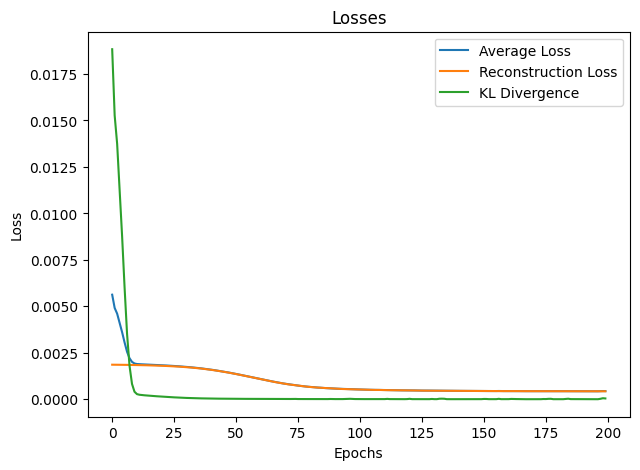

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_shape, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, latent_dim * 2)  # mean and variance
        )

    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = h.chunk(2, dim=1)
        return mu, log_var, h


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_shape):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, output_shape),
        )

    def forward(self, z):
        x_reconstructed = self.decoder(z)
        return x_reconstructed


class VAE(nn.Module):
    def __init__(self, input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim1, hidden_dim2, hidden_dim3, input_shape)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var, h = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, log_var

    
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split

# Assuming combined_tensor is your data
# Convert the data to float32
dataset = TensorDataset(combined_tensor.float())

# Define the data loader
batch_size = 512  # adjust as necessary

# Split data into train, validation, and test
train_size = int(0.7 * len(dataset))  # 70% for training
valid_size = int(0.15 * len(dataset))  # 15% for validation
test_size = len(dataset) - train_size - valid_size  # 15% for testing

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Hyperparameters
# input_shape = combined_tensor.shape[1] * combined_tensor.shape[2]  # modify this to match your data
# hidden_dim1 = 128  # modify as needed
# hidden_dim2 = 64  # modify as needed
# hidden_dim3 = 24  # modify as needed
# latent_dim = 2  # modify as needed
# lr = 5e-5  # learning rate
# n_epochs = 200  # modify as needed
# beta = 0.2
input_shape = combined_tensor.shape[1] * combined_tensor.shape[2]  # modify this to match your data
hidden_dim1 = 64  # modify as needed
hidden_dim2 = 32  # modify as needed
hidden_dim3 = 8  # modify as needed
latent_dim = 2  # modify as needed
lr = 5e-5  # learning rate
n_epochs = 200  # modify as needed
beta = 0.2
    
    
# Model, optimizer, and loss function
model = VAE(input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim)


optimizer = optim.RAdam(model.parameters(), lr=lr)  # Make sure you're using the correct optimizer
loss_fn = nn.MSELoss()  # And the correct loss function


def train(epoch, model, optimizer, loss_fn, train_loader):
    model.train()
    train_loss = 0
    total_recon_loss = 0
    total_kl_div = 0
    for i, batch in enumerate(train_loader):  # using train_loader instead of dataloader
        batch_data = batch[0]  # get the data from the batch
        
        optimizer.zero_grad()

        # Flatten the data
        batch_data = batch_data.view(batch_data.size(0), -1)

        reconstructed_batch, mu, log_var = model(batch_data)

        # Loss: reconstruction loss + KL divergence
        recon_loss = loss_fn(reconstructed_batch, batch_data)
        kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + beta*kl_divergence

        loss.backward()
        train_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_div += kl_divergence.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon_loss = total_recon_loss / len(train_loader.dataset)
    avg_kl_div = total_kl_div / len(train_loader.dataset)
    print(f'====> Epoch: {epoch} Average loss: {avg_loss}, Recon Loss: {avg_recon_loss}, KL Div: {avg_kl_div}')

    return avg_loss, avg_recon_loss, avg_kl_div

    
import matplotlib.pyplot as plt

# Lists to store losses for each epoch
avg_losses = []
avg_recon_losses = []
avg_kl_divs = []

# Training
for epoch in range(1, n_epochs + 1):
    avg_loss, avg_recon_loss, avg_kl_div = train(epoch, model, optimizer, loss_fn, train_loader)
    avg_losses.append(avg_loss)
    avg_recon_losses.append(avg_recon_loss)
    avg_kl_divs.append(avg_kl_div)

# Plot the losses
plt.figure(figsize=(7,5))
plt.plot(avg_losses, label='Average Loss')
plt.plot(avg_recon_losses, label='Reconstruction Loss')
plt.plot(avg_kl_divs, label='KL Divergence')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [4]:
def evaluate(model, loss_fn, dataloader):
    model.eval()
    loss = 0
    total_recon_loss = 0
    total_kl_div = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            batch_data = batch[0]  # get the data from the batch

            # Flatten the data
            batch_data = batch_data.view(batch_data.size(0), -1)

            reconstructed_batch, mu, log_var = model(batch_data)

            # Loss: reconstruction loss + KL divergence
            recon_loss = loss_fn(reconstructed_batch, batch_data)
            kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss += recon_loss + kl_divergence
            total_recon_loss += recon_loss.item()
            total_kl_div += kl_divergence.item()

    avg_loss = loss / len(dataloader.dataset)
    avg_recon_loss = total_recon_loss / len(dataloader.dataset)
    avg_kl_div = total_kl_div / len(dataloader.dataset)

    return avg_loss, avg_recon_loss, avg_kl_div
evaluate(model, loss_fn, test_loader)

(tensor(0.0004), 0.0004224401613076528, 1.7504314581553143e-05)

# latent space plot

In [5]:
# with torch.no_grad():
#     for batch in test_loader:
#         batch_data = batch[0]
#         batch_data = batch_data.view(batch_data.size(0), -1)
#         mu, log_var = model.encoder(batch_data)
#         print("mu is ", mu)
#         print("log_var is ", log_var)

# render with action

In [6]:

import torch

# Convert combined_arr to PyTorch Tensor
# combined_tensor = torch.from_numpy(combined_arr)

# Print the shape of combined_tensor
print(combined_tensor.shape)

import matplotlib.pyplot as plt
from IPython import display
import gym


def replay(combined_data):

    action_sp = combined_data.iloc[:, :2]
    obs_sp = combined_data.iloc[:, 2:]

    env = gym.make('Swimmer-v3', render_mode = 'human')

    # Iterate through the rows
    for i in range(len(action_sp)):
        # Get the i-th row
        action = action_sp.iloc[i]
        observation = obs_sp.iloc[i]
#         print(action)

        # If this is the first iteration, set the environment state to the given observation
        # Note: This assumes that the observation you've stored is the entire state that can be set with `env.reset()`
        # If this is not the case, you cannot simply set the environment state to the observation
        if i == 0:
            env.reset()  # We ignore the initial observation returned by `reset`

        # Apply the action
        next_observation, reward, done, trunc, info = env.step(action)
        # Render the environment
        env.render()
        # If you want to slow down each step for viewing, you can use time.sleep
        # time.sleep(0.01)

    # Close the environment
    env.close()


torch.Size([10000, 1000, 10])


# render with action save

In [7]:
from gym import wrappers
from gym.wrappers.monitoring.video_recorder import VideoRecorder

def replay_save(combined_data):
    action_sp = combined_data.iloc[:, :2]
    obs_sp = combined_data.iloc[:, 2:]

    env = gym.make('Swimmer-v4', render_mode = 'human')
    outputvid_dir = os.path.join(".", "video", "video.mp4")
    print(outputvid_dir)
    vid_recorder = VideoRecorder(env=env, path=outputvid_dir ,enabled=True)
#     vid_recorder = VideoRecorder(env, path=outputvid_dir) # Video file path
    
    # Iterate through the rows
    for i in range(len(action_sp)):
        action = action_sp.iloc[i]
        observation = obs_sp.iloc[i]

        if i == 0:
            env.reset()

        # Apply the action
        next_observation, reward, done, trunc, info = env.step(action)
        
        # Render the environment
        env.render()

        # Capture frame for video
        vid_recorder.capture_frame()
#         print('video saved')

    # Close the environment and video recorder
    vid_recorder.close()
    env.close()

# see the output

In [ ]:
def test_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            batch_data = batch[0]  # get the data from the batch
            batch_data = batch_data.view(batch_data.size(0), -1)  # flatten the data
            reconstructed_batch, _, _ = model(batch_data)  # get reconstructed data from the model

            # Convert tensors to numpy arrays for use in pandas
            original_data = batch_data.detach().cpu().numpy()
            reconstructed_data = reconstructed_batch.detach().cpu().numpy()

            # Convert to dataframes
            original_df = pd.DataFrame(original_data)
            reconstructed_df = pd.DataFrame(reconstructed_data)

            if i == 0:  # for the first iteration, create the dataframes
                all_original_df = original_df
                all_reconstructed_df = reconstructed_df
            else:  # for subsequent iterations, append to the existing dataframes
                all_original_df = pd.concat([all_original_df, original_df])
                all_reconstructed_df = pd.concat([all_reconstructed_df, reconstructed_df])
    
    return all_original_df, all_reconstructed_df

# Call the function after training
original_df, reconstructed_df = test_model(model, test_loader)


In [ ]:
original_df

In [ ]:
reconstructed_df

In [ ]:
# Get the first row from the dataframe
first_row_reco = reconstructed_df.iloc[0]

# Reshape it to (1000, 10)
reshaped_reco_array = np.reshape(first_row_reco.values, (1000, 10))

# Convert it back to a dataframe
reshaped_df_reco = pd.DataFrame(reshaped_reco_array)
recon_combined_tensor = torch.tensor(reshaped_df_reco.values)


In [ ]:
replay(reshaped_df_reco)

In [ ]:
# replay_save(reshaped_df_reco)

In [ ]:
# Get the first row from the dataframe
first_row_ori = original_df.iloc[0]

# Reshape it to (1000, 10)
reshaped_array_ori = np.reshape(first_row_ori.values, (1000, 10))

# Convert it back to a dataframe
reshaped_df_ori = pd.DataFrame(reshaped_array_ori)
ori_combined_tensor = torch.tensor(reshaped_df_ori.values)


In [ ]:
replay(reshaped_df_ori)

In [ ]:
# Flatten the tensors
flattened_ori = ori_combined_tensor.flatten()
flattened_recon = recon_combined_tensor.flatten()

# Calculate the Euclidean distance
euclidean_distance = torch.norm(flattened_ori - flattened_recon)


print(euclidean_distance)


In [ ]:
ori_combined_np = original_df.to_numpy()
recon_combined_np = reconstructed_df.to_numpy()

# Column names
column_names = ['action space : Torque applied on the first rotor', 
                'action space : Torque applied on the second rotor', 
                'obs0:angle of the front tip', 'obs1: angle of the first rotor', 
                'obs2: angle of the second rotor', 'obs3: velocity of the tip along the x-axis',
                'obs4: velocity of the tip along the y-axis', 'obs5: angular velocity of front tip',
                'obs6: angular velocity of first rotor', 'obs7: angular velocity of second rotor']

# Create a figure
plt.figure(figsize=(20, 20))

# Create subplots for each column
for i in range(10):  # Assuming you have 10 columns
    plt.subplot(5, 2, i+1)  # 5 rows and 2 columns of subplots
    plt.scatter(ori_combined_np[i, :], recon_combined_np[i, :], alpha=0.5, s=5)
    plt.title(column_names[i])
    plt.xlabel('Original')
    plt.ylabel('Reconstructed')

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
ori_combined_np.shape

In [ ]:
# Column names
column_names = ['action space : Torque applied on the first rotor', 
                'action space : Torque applied on the second rotor', 
                'obs0', 'obs1', 'obs2', 'obs3', 'obs4', 'obs5', 'obs6', 'obs7']

# Create a figure
plt.figure(figsize=(20, 20))

# Create subplots for each column
for i in range(10):  # Assuming you have 10 columns
    plt.subplot(5, 2, i+1)  # 5 rows and 2 columns of subplots
    plt.scatter(ori_combined_np[:, i], recon_combined_np[:, i], alpha=0.2)
    plt.title(column_names[i])
    plt.xlabel('Original')
    plt.ylabel('Reconstructed')

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
# Test

In [ ]:
# Get encoded representations (h values) for all data points
encoded_representations = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch_data = batch[0]
        batch_data = batch_data.view(batch_data.size(0), -1)
        batch_data = batch_data.float()
        _, _, h = model.encoder(batch_data)  # Get the encoded representation (h value) directly
        encoded_representations.append(h)

encoded_representations = torch.cat(encoded_representations, dim=0).numpy()

# Assuming the encoded representations are 2D, plot the data in 2D space
plt.figure(figsize=(8, 6))
plt.scatter(encoded_representations[:, 0], encoded_representations[:, 1], alpha=0.5, s=3)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Visualization of Encoded Representations (h values)')
plt.show()


In [ ]:
# Get encoded representations (h values) for all data points
encoded_representations = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch_data = batch[0]
        batch_data = batch_data.view(batch_data.size(0), -1)
        batch_data = batch_data.float()
        _, _, h = model.encoder(batch_data)  # Get the encoded representation (h value) directly
        encoded_representations.append(h)

encoded_representations = torch.cat(encoded_representations, dim=0).numpy()

# Assuming the encoded representations are 2D, plot the data in 2D space
plt.figure(figsize=(8, 6))
plt.scatter(encoded_representations[:, 0], encoded_representations[:, 2], alpha=0.5, s=3)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Visualization of Encoded Representations (h values)')
plt.show()
